In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
%matplotlib inline

/home/tadenoud/Git/simple-faster-rcnn-pytorch/utils/vis_tool.py:8: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


In [2]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

# Load model trained with caffe pretrained model

In [3]:
trainer.load('./checkpoints/fasterrcnn_02202207_0.6666273688828848')
opt.caffe_pretrain=True # this model was trained from caffe-pretrained model

In [4]:
img = read_image('misc/demo.jpg')
img = t.from_numpy(img)[None]

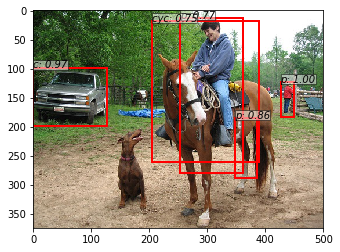

In [5]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# Display a Kitti image

In [6]:
import os

# dataset_dir = '/media/tadenoud/DATADisk/datasets/kitti_2d'  # School comp
dataset_dir = '/home/tadenoud/Documents/kitti' # Laptop

img_paths = [
    os.path.join(dataset_dir, 'training/image_2/005009.png'),
    os.path.join(dataset_dir, 'training/image_2/005010.png')
]

imgs = np.array([read_image(p) for p in img_paths])

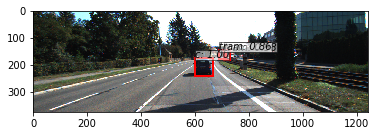

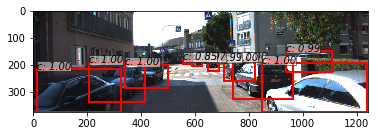

In [7]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

In [8]:
# Read a Kitti GT label
from data.util import read_bbox

img_label_paths = [
    os.path.join(dataset_dir, 'training/label_2/005009.txt'),
    os.path.join(dataset_dir, 'training/label_2/005010.txt')
]

gt = np.array([read_bbox(p, ignore_dontcare=True) for p in img_label_paths]) 
gt_bboxes = gt[:,0]
gt_labels = gt[:,1]

# Train mahalanobis features with entire training dataset

In [9]:
from utils.config import opt
from data.dataset import Dataset
from torch.utils.data import DataLoader


print('load data') 
dataset = Dataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False, \
                        # pin_memory=True,
                        num_workers=opt.num_workers)


mahal_means, mahal_cov = trainer.faster_rcnn.train_ood(dataloader)

0it [00:00, ?it/s]

load data
extracting features


3711it [18:33,  3.33it/s]

calculating feature means
calculating feature covariance
inverting feature covariance


In [10]:
mahal_means

[array([0.30541256, 0.5427772 , 0.98912543, ..., 0.02667478, 0.08587455,
        0.6279755 ], dtype=float32),
 array([0.28697923, 0.8243787 , 1.5409836 , ..., 0.00995852, 0.2205768 ,
        0.89854586], dtype=float32),
 -1,
 array([0.32559502, 0.8205151 , 1.3189285 , ..., 0.03437825, 0.18403494,
        0.78377503], dtype=float32),
 array([0.35226408, 0.94067836, 1.4219537 , ..., 0.05880148, 0.26499614,
        0.672376  ], dtype=float32),
 array([0.3862205 , 0.5325446 , 0.7897332 , ..., 0.01138667, 0.12014011,
        0.48740542], dtype=float32),
 array([0.34722266, 0.4091352 , 0.5782483 , ..., 0.01441903, 0.04167857,
        0.4121369 ], dtype=float32),
 array([0.45745227, 0.7220546 , 1.1311282 , ..., 0.00447493, 0.14133802,
        0.7044416 ], dtype=float32),
 -1,
 array([0.25833562, 0.52184165, 1.0762075 , ..., 0.03972476, 0.07854244,
        0.6319526 ], dtype=float32)]

In [11]:
import pickle
with open('kitti_features.pickle', 'wb') as f:
    pickle.dump(trainer.faster_rcnn.features, f)

trainer.faster_rcnn.features.shape

(26018, 4096)

In [12]:
from tqdm import tqdm
gt_labels = []

for ii, (img, bbox_, label_, scale) in tqdm(enumerate(dataloader), total=3711):
    gt_labels.append(at.tonumpy(label_[0]))

    if ii == 3711:
        break
        
gt_labels = np.concatenate(gt_labels, axis=0)


  8%|▊         | 286/3711 [00:26<05:18, 10.76it/s]


 12%|█▏        | 437/3711 [00:51<06:27,  8.44it/s]


 20%|█▉        | 726/3711 [01:17<05:18,  9.38it/s]


 27%|██▋       | 997/3711 [01:41<04:36,  9.81it/s]


 35%|███▍      | 1282/3711 [02:06<04:00, 10.12it/s]


 43%|████▎     | 1578/3711 [02:31<03:25, 10.40it/s]


 50%|█████     | 1874/3711 [02:57<02:53, 10.56it/s]


 58%|█████▊    | 2169/3711 [03:23<02:24, 10.67it/s]


 66%|██████▋   | 2465/3711 [03:48<01:55, 10.81it/s]


 74%|███████▍  | 2761/3711 [04:13<01:27, 10.90it/s]


 82%|████████▏ | 3057/3711 [04:39<00:59, 10.95it/s]


 90%|█████████ | 3353/3711 [05:05<00:32, 10.99it/s]


 98%|█████████▊| 3649/3711 [05:31<00:05, 11.01it/s]


100%|██████████| 3711/3711 [05:36<00:00, 11.01it/s]

In [13]:
with open('kitti_labels.pickle', 'wb') as f:
    pickle.dump(gt_labels, f)
    
with open('mahal_means.pickle', 'wb') as f:
    pickle.dump(mahal_means, f)

with open('mahal_cov.pickle', 'wb') as f:
    pickle.dump(mahal_cov, f)

In [14]:
VOC_BBOX_LABEL_NAMES = (
    'car',
    'van',
    'bus',
    'truck',
    'tram',
    'person',
    'person_sitting',
    'cyclist',
    'motorbike',
    'misc'
    # 'dontcare
)

for j in range(10):
    print(VOC_BBOX_LABEL_NAMES[j], "count:", sum([i == j for i in gt_labels]))

car count: 14081
van count: 1468
bus count: 0
truck count: 529
tram count: 265
person count: 2272
person_sitting count: 117
cyclist count: 837
motorbike count: 0
misc count: 497


In [15]:
mahal_cov

array([[ 0.03376208,  0.03802033,  0.0394701 , ..., -0.00341658,
         0.004519  ,  0.02975364],
       [ 0.03802033,  0.12013515,  0.10827265, ..., -0.00888183,
         0.01460946,  0.07114232],
       [ 0.0394701 ,  0.10827265,  0.22736826, ..., -0.01062037,
         0.01617262,  0.10407229],
       ...,
       [-0.00341658, -0.00888183, -0.01062037, ...,  0.00418351,
        -0.00049639, -0.00754856],
       [ 0.004519  ,  0.01460946,  0.01617262, ..., -0.00049639,
         0.02046443,  0.01032141],
       [ 0.02975364,  0.07114232,  0.10407229, ..., -0.00754856,
         0.01032141,  0.10746007]])

In [16]:
print("Zeros in cov matrix:", (lambda a, b: a * b)(*mahal_cov.shape) - np.count_nonzero(mahal_cov))

Zeros in cov matrix: 106327


In [17]:
trainer.faster_rcnn.inv_mahal_cov

array([[ 3.31108153e+03, -1.11557953e+02,  3.37082522e+00, ...,
         8.06885068e+01,  2.08785668e+01,  6.08503334e+01],
       [-1.11557953e+02,  2.85215986e+03,  1.83292726e+01, ...,
         5.21499718e+01, -7.22056787e+01, -1.25049095e+01],
       [ 3.37082524e+00,  1.83292727e+01,  1.90341210e+03, ...,
        -1.33180285e+01, -5.99794979e+01,  3.91361782e+01],
       ...,
       [ 8.06885068e+01,  5.21499718e+01, -1.33180285e+01, ...,
         4.72412289e+03, -3.63936386e+01,  7.70214947e+01],
       [ 2.08785668e+01, -7.22056787e+01, -5.99794979e+01, ...,
        -3.63936386e+01,  2.77235006e+03,  3.55216004e+01],
       [ 6.08503334e+01, -1.25049095e+01,  3.91361782e+01, ...,
         7.70214947e+01,  3.55216004e+01,  1.84508419e+03]])

In [ ]:
import matplotlib.pyplot as plt
from sklearn import manifold
from time import time

# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(trainer.faster_rcnn.features)
y = gt_labels

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

Computing t-SNE embedding



100%|██████████| 3711/3711 [05:48<00:00, 10.66it/s]